In [2]:
#Uncomment this if you want to install the packages
!pip install -U jax
!pip install distrax
!pip install tensorflow
!pip install tensorflow-probability
# !pip install numpyro
!pip install optax
# !pip uninstall -y blackjax


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.15-py3-none-any.whl size=1201903 sha256=78c8b66e32251aad1df57a7feca6fdde9131e78747cd9c24bfbd0ec4d5d0d503
  Stored in directory: /root/.cache/pip/wheels/59/9d/cb/21506ed546ffa6e339e75a0bb7500d363d68349a89f9c5a080
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
# !git clone https://github.com/Habush/blackjax.git
!cd blackjax
!git remote update
!git fetch
!git checkout --track origin/exp
!pip install .

Fetching origin
fatal: 'origin/exp' is not a commit and a branch 'exp' cannot be created from it
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import distrax
import blackjax
import seaborn as sns
import scipy
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload

/home/xabush/miniconda3/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [3]:
plt.style.use("ggplot")

In [4]:
def jax_prng_key():
    return jax.random.PRNGKey(np.random.randint(int(1e5)))

In [5]:
# rng_key = jax_prng_key()
rng_key = jax.random.PRNGKey(0)

In [6]:
jax.default_backend()

'gpu'

In [13]:
from jax.experimental.host_callback import id_print


## Inference loop implemented using lax.scan
def inference_loop(rng_key, kernel, initial_state, num_samples):
  @jax.jit
  def one_step(state, rng_key):
    state, _ = kernel(rng_key, state)
    return state, state

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states



def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
  
  def one_step(states, rng_key):
    keys = jax.random.split(rng_key, num_chains)
    states, _ = jax.vmap(kernel)(keys, states)
    return states, states

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states 

def get_ess(chain, burn_in):
    c = chain
    l = c.shape[0]
    bi = int(burn_in * l)
    c = c[bi:]
    cv = tfp.mcmc.effective_sample_size(c)
    cv = cv.at[jnp.isnan(cv)].set(1.)
    return cv

### Gaussian Mixture Model

In [7]:
n_comp = 2
# pi = np.array([0.15, 0.3, 0.3, 0.25])
pi = jnp.array([0.6, 0.4])
# mu_list = jnp.array([-2, 0, 2, 4]).reshape(n_comp,)
mu_list = np.array([-2., 4.]).reshape(n_comp,)
Sigma_list = (0.1 * np.stack([np.eye(1) for _ in range(pi.shape[0])])).reshape(n_comp,)
# Sigma_list = jnp.array([0.1, 1.])
N = 1000
rng_key = jax.random.PRNGKey(0)

def generate_gmm_samples(rng_key, pi, locs, scales, N=1000):

  gmm = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(
          probs=pi),
      components_distribution=tfd.Normal(
        loc=locs,       # One for each component.
        scale=scales))

  samples = gmm.sample(seed=jax_prng_key(), sample_shape=(N,))
  cls = gmm.posterior_marginal(samples).sample(seed=jax_prng_key())
  print(cls.shape)
  return jnp.array(cls, dtype=jnp.float32), samples

def one_hot_encode(cat, total_cat=4):
  return jnp.array(jnp.array([cat])[...,None] == jnp.arange(total_cat), dtype=jnp.float32)

(1000,)


<AxesSubplot:ylabel='Density'>

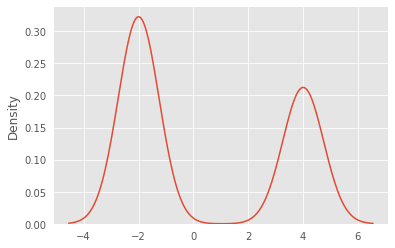

In [8]:
cls, samples = generate_gmm_samples(jax_prng_key(), pi, mu_list, Sigma_list)
sns.kdeplot(data=samples)

In [9]:
from jax.scipy.stats import norm


# def generate_simple_gmm_potential(pi, locs, scales):
#     gmm = tfd.MixtureSameFamily(
#       mixture_distribution=tfd.OneHotCategorical(
#           probs=pi),
#       components_distribution=tfd.Normal(
#         loc=locs,       # One for each component.
#         scale=scales))

      
#     def simple_gmm_potential(z, x):
#         # z, x = position
#         # k = one_hot_encode(z, n_comp)
#         # log_mix_prob = jax.nn.log_softmax(
#         # gmm.mixture_distribution.logits_parameter(), axis=-1)
#         log_x = gmm._per_mixture_component_log_prob(x)
        
#         # k = jnp.int32(z)
#         # print(f"z: {z}, x: {x}, k: {k}, log_x: {log_x}")
#         return z*log_x[1] + (1. - z)*log_x[0]

#     return simple_gmm_potential


def generate_simple_gmm_potential(pi, locs, scales):
    component_dist = tfd.Normal(loc=locs, scale=scales)

    def get_cluster_assignment(z, x):
        
        unnormalized_posterior = component_dist.log_prob(x) + jnp.log(pi)
        # print(unnormalized_posterior)
        # posterior = unnormalized_posterior - jax.nn.logsumexp(unnormalized_posterior, axis=-1)
        # posterior = jnp.mean(posterior, axis=1)
        # print(posterior)
        k = jnp.int32(z)
        return unnormalized_posterior[k][0]


    return get_cluster_assignment


In [10]:
gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=pi),
    components_distribution=tfd.Normal(
      loc=mu_list,       # One for each component.
      scale=Sigma_list))

(2, 1)
=

<AxesSubplot:ylabel='Density'>

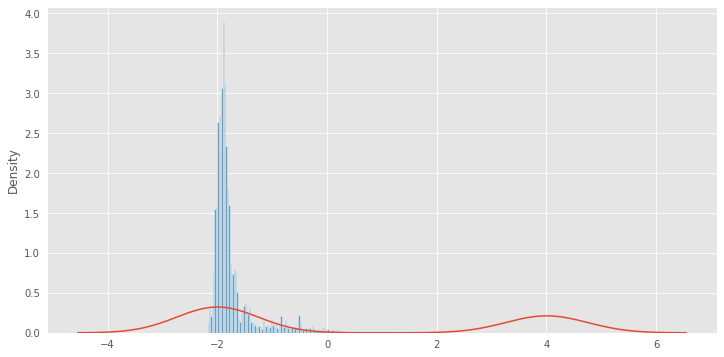

In [13]:
# %autoreload
# import blackjax

mu_list = np.array([-2., 4.]).reshape(n_comp,)
Sigma_list = (0.1 * np.stack([np.eye(1) for _ in range(pi.shape[0])])).reshape(n_comp,)
discrete_step = 0.2
contin_step = 1e-5

## Different initialization points result in d/t sampling
L = 2
num_samples = 10000
# logprob_fn = generate_simple_gmm_potential(pi, mu_list, Sigma_list)
logprob_fn = lambda z, x : jnp.sum(jax.vmap(gmm.log_prob)(x))
grad_fn = jax.grad(logprob_fn, argnums=1)
mixed_mala = blackjax.mixed_mala(logprob_fn, grad_fn, grad_fn, discrete_step, 
                                 contin_step, L)


states = []

disc_init_pos = np.random.randint(0, 2, size=2)[...,None] * 1.
contin_init_pos = np.random.normal(size=2)[...,None]
print(contin_init_pos.shape)
init_state = mixed_mala.init((disc_init_pos, contin_init_pos))
mm_kernel = jax.jit(mixed_mala.step)
post_samples = mm_inference_loop(jax_prng_key(), mm_kernel, init_state, num_samples)
print("=", end="")

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=post_samples.position.contin_position.reshape(-1,), ax=ax, stat="density", bins=100)
sns.kdeplot(data=samples, ax=ax, legend="ground truth")

### Currently Not working (due to API Change)

In [14]:
discrete_step = 1e-5
contin_step = 5e-5

## Different initialization points result in d/t sampling

L = 2

logprob_fn = generate_simple_gmm_potential(pi, mu_list, Sigma_list)
logprob = lambda z, x : jnp.sum(jax.vmap(logprob_fn)(z, x))
grad_fn = jax.grad(logprob_fn, argnums=1)
mixed_mala = blackjax.mixed_mala(logprob_fn, grad_fn, grad_fn, discrete_step, 
                                 contin_step, L)


disc_init_pos = cls[:10][...,None]
contin_init_pos = samples[:10][...,None]
init_state = mixed_mala.init((disc_init_pos, contin_init_pos))
mm_kernel = jax.jit(mixed_mala.step)
post_samples = mm_inference_loop(jax_prng_key(), mm_kernel, init_state, 10_000)
print("=", end="")

fig, ax = plt.subplots(figsize=(6, 6))

sns.histplot(data=post_samples.position.contin_position.reshape(-1, 1), ax=ax, stat="density", bins=100)
sns.kdeplot(data=samples, ax=ax, legend="ground truth")
# ax.set_title(f"Cat {i+1} - $\mu = {mu_list[i]}$")
# ax.set_xlim(-3, 5)


TypeError: Gradient only defined for scalar-output functions. Output had shape: (1, 2).

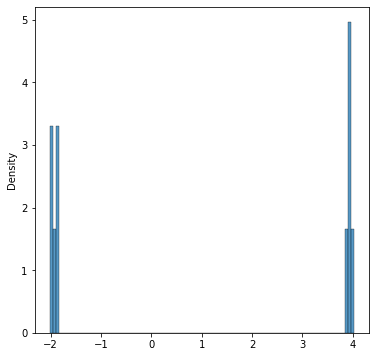

In [ ]:

fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=samples[:10], ax=ax, stat="density", bins=100)

In [ ]:
post_samples.position.contin_position.shape

(10000, 10, 1)

### Test the Mixed MALA on synthetic dataset

In [7]:
def generate_betas(sz, tf, n_genes, val_tf, val_genes, num_pos=-1):
    if num_pos > n_genes:
        raise ValueError(f"Number of positive genes {num_pos} must be less than or equal to number of genes {n_genes}. To set all "
                         f"genes to positive, set it to -1")
    beta = np.zeros(sz)

    k = (tf + (tf * n_genes))
    st = n_genes + 1
    m = 0
    for i in range(k):
        if i % st == 0:
            beta[i] = val_tf[m]
            z = 0
            for j in range(i + 1, i + st):
                if num_pos < 0:
                    beta[j] = val_tf[m]/val_genes
                else:
                    if z < num_pos:
                        beta[j] = val_tf[m]/val_genes
                    else:
                        beta[j] = -val_tf[m]/val_genes
                    z += 1
            m += 1

    return beta

def generate_data_v2(tf, genes, tf_on=4, corr=0.7, val_tf=None, val_gene=np.sqrt(10), num_pos=-1, n=100):
    if val_tf is None:
        val_tf = [2, 2, 2, 2]
    sz = (tf + (tf * genes))
    X = np.zeros((n, sz))
    assert len(val_tf) == tf_on
    m = genes + 1
    for t in range(0, m*tf, m):
        X_tf = np.random.normal(0, 1, size=n)
        X[:,t] = X_tf
        for g in range(t + 1, t + m):
            X_g = np.random.normal(corr*X_tf, 0.51, size=n)
            X[:,g] = X_g

    beta = generate_betas(sz, tf_on, genes, val_tf, val_gene, num_pos=num_pos)

    sd_e = np.sqrt(np.sum(np.square(beta)) / 4)
    err = np.random.normal(np.zeros(n), sd_e, size=n)

    y = (X @ beta) + err

    return X, beta, y


def generate_log_data(tf, genes, tf_on=4, corr=0.7, val_tf=None, val_gene=np.sqrt(10), num_pos=-1, n=100):
   if val_tf is None:
       val_tf = [2, 2, 2, 2]
   X, beta, y_lin = generate_data_v2(tf, genes, tf_on=tf_on, corr=corr, val_tf=val_tf, val_gene=val_gene, num_pos=num_pos, n=n)
   print(f"y_lin shape : {y_lin.shape}")
   y_dist = tfd.Bernoulli(logits=y_lin)
   print(y_dist)
   y_log = y_dist.sample(seed=jax_prng_key())

   return X, beta, y_log

def get_assoc_mat(tf, genes, corr=1, bias=False):
    feats = tf + (tf * genes)
    assoc_mat = np.eye(feats, feats)
    m = genes + 1
    for t in range(0, m * tf, m):
        for g in range(t + 1, t + m):
            assoc_mat[t, g] = 1
            assoc_mat[g, t] = 1
    if bias:
        zero_col = np.zeros((assoc_mat.shape[0], 1))
        zero_row = np.zeros((1, assoc_mat.shape[0] + 1))
        assoc_mat = np.hstack((zero_col, assoc_mat))
        return np.vstack((zero_row, assoc_mat))
    return assoc_mat

In [8]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)
X, beta_true, y = generate_data_v2(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
J = get_assoc_mat(20, 10, 1)
np.fill_diagonal(J, 0.)
p = J.shape[1]

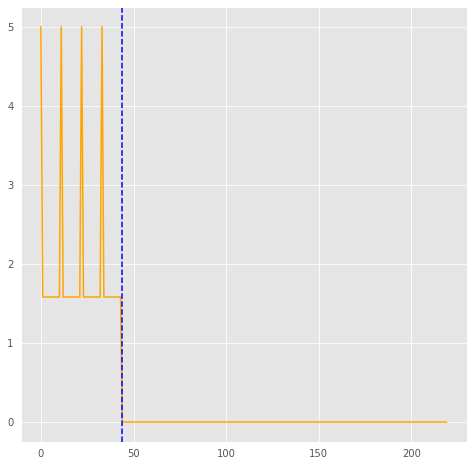

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(0, p), beta_true, color="orange")
ax.axvline(x=44, linestyle="--", color="blue", label="i = 20")

In [10]:
from jax.experimental.host_callback import id_print
def gamma_energy(theta, J, eta, mu):
  # x = theta
  x = (2 * theta) - 1
  xg = x @ J
  xgx = jnp.sum((xg * x), axis=-1)
  return eta*xgx + mu*jnp.sum(x)


# def gamma_energy(theta, J, eta, mu):
  
#   return eta*((theta.T @ J) @ theta) + mu*jnp.sum(theta)

### Check for phase transition in the Ising Model (See Li & Zhang 2014)

In [101]:
np.geomspace(0.1, 50, 50)

array([ 0.1       ,  0.11352226,  0.12887303,  0.14629957,  0.16608258,
        0.18854069,  0.21403565,  0.24297811,  0.27583423,  0.31313325,
        0.35547593,  0.40354431,  0.45811261,  0.52005978,  0.5903836 ,
        0.6702168 ,  0.76084524,  0.8637287 ,  0.98052432,  1.11311334,
        1.2636314 ,  1.4345029 ,  1.62848008,  1.84868736,  2.09867163,
        2.38245942,  2.70462173,  3.07034766,  3.48552798,  3.95685007,
        4.49190554,  5.09931259,  5.78885479,  6.57163867,  7.4602726 ,
        8.4690699 ,  9.61427938, 10.91434703, 12.39021318, 14.06564977,
       15.96764321, 18.12682911, 20.57798569, 23.36059399, 26.51947376,
       30.1055054 , 34.17644949, 38.79787713, 44.04422614, 50.        ])

In [24]:
a = -5
n = 50
b_values = np.geomspace(0.1, 50, n)
keys = jax.random.split(rng_key, n)
num_gamma_on = np.zeros(n)
ess_stat = np.zeros(n)
num_samples = 20000
burnin = 0.1
cat_dist = tfd.Bernoulli(probs=[0.5]*p)
chains = np.zeros((n, num_samples, p))

for i in range(b_values.shape[0]):
    b = b_values[i]
    print(f"Current b val: {b:.3f}")
    step_size = 0.2
    init_pos = cat_dist.sample(seed=keys[i]) * 1.
    logprob = lambda x: gamma_energy(x, J, b, a)
    curr_state = blackjax.dmala.init(init_pos, logprob)
    dmala = blackjax.dmala(logprob, step_size)
    dmala_kernel = jax.jit(dmala.step)
    sample_keys = jax.random.split(keys[i], num_samples)
    for j in range(num_samples):
        curr_state, _ = dmala_kernel(sample_keys[j], curr_state)
        chains[i, j] = curr_state.position

    mean = np.mean(np.sum(chains[i, int(burnin*num_samples):], axis=1), axis=0)
    num_gamma_on[i] = mean
    ess = get_ess(chains[i], burnin)
    ess_stat[i] = jnp.mean(ess)

[Text(0, -0.1, '-10.00%'),
 Text(0, 0.0, '0.00%'),
 Text(0, 0.1, '10.00%'),
 Text(0, 0.20000000000000004, '20.00%'),
 Text(0, 0.30000000000000004, '30.00%'),
 Text(0, 0.4, '40.00%'),
 Text(0, 0.5000000000000001, '50.00%'),
 Text(0, 0.6000000000000001, '60.00%')]

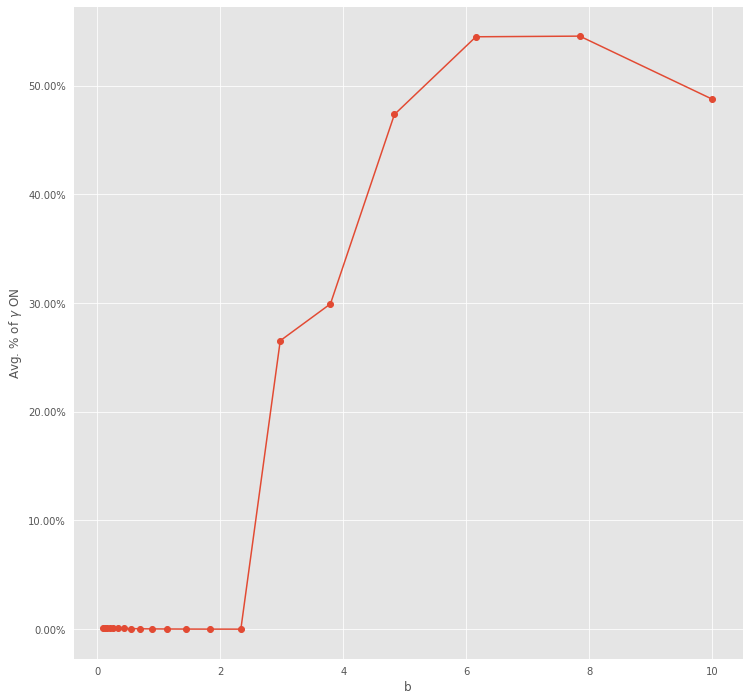

In [100]:
percent_on = (num_gamma_on / p)
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(b_values, percent_on, marker='o')

# ax.set_xscale("log")
ax.set_xlabel("b")
ax.set_ylabel(r"Avg. % of $\gamma$ ON")
y_ticks = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in y_ticks])

[Text(0, -0.1, '-10.00%'),
 Text(0, 0.0, '0.00%'),
 Text(0, 0.1, '10.00%'),
 Text(0, 0.20000000000000004, '20.00%'),
 Text(0, 0.30000000000000004, '30.00%'),
 Text(0, 0.4, '40.00%'),
 Text(0, 0.5000000000000001, '50.00%'),
 Text(0, 0.6000000000000001, '60.00%'),
 Text(0, 0.7000000000000001, '70.00%')]

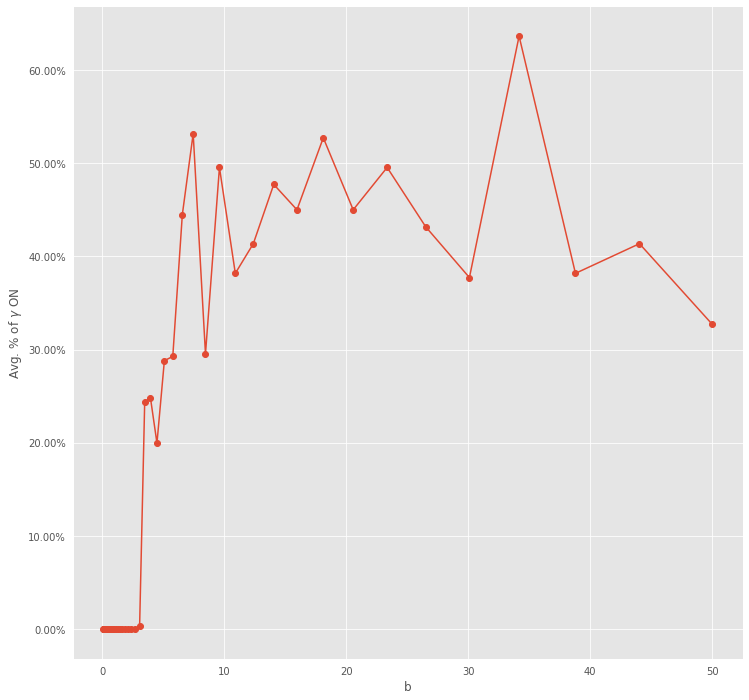

In [103]:
percent_on = (num_gamma_on / p)
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(b_values, percent_on, marker='o')

# ax.set_xscale("log")
ax.set_xlabel("b")
ax.set_ylabel(r"Avg. % of $\gamma$ ON")
y_ticks = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in y_ticks])

### Find suitable $\mu$ and $\eta$ values using Fan Li. et al 2015.

    $$(a + 8b)V^2 - 12bV + 4b >  \frac{-n . R^{2}}{2(1 - R^{2})}$$

In [11]:
r2_scores = np.zeros(p)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

n = X_train.shape[0]
for j in range(p):
    X_j = X_train[:,j].reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(X_j, y_train)
    y_pred = reg.predict(X_j)
    r2_scores[j] = r2_score(y_train, y_pred)


r2_max = np.max(r2_scores)
V = 2
print(f"Max R2 - {r2_max}, V - {V}")

Max R2 - 0.32171414137111876, V - 2


In [14]:
b_max = 0.83 # calculated using the above equation
a_min = -6.3


num_gamma_on = np.zeros(n)
ess_stat = np.zeros(n)
num_samples = 10000
burnin = 0.1
step_size = 0.2
cat_dist = tfd.Bernoulli(probs=[0.5] * p)
init_pos = cat_dist.sample(seed=rng_key) * 1.
logprob = lambda x: gamma_energy(x, J, b_max, a_min)
init_state = blackjax.dmala.init(init_pos, logprob)
dmala = blackjax.dmala(logprob, step_size)
dmala_kernel = jax.jit(dmala.step)

states = inference_loop(rng_key, dmala_kernel, init_state, num_samples)
mean = np.mean(np.sum(states.position[int(burnin*num_samples):], axis=1))
percent_on = (mean / p) * 100
print(f"mean - {mean:.3f}, % ON - {percent_on:.3f}")

mean - 0.007, % ON - 0.003


In [116]:
EPS = 1e-12
init_gamma_dist = tfd.Bernoulli(probs=[0.5]*p)
init_beta_dist = tfd.Normal(loc=jnp.zeros(p) ,scale=jnp.ones(p))

In [31]:
# Prior distributions of the training variables
# Upperbound on K
max_cluster_num = 20
dims = 1
#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.

joint_dist = tfd.JointDistributionNamed(dict(
    alpha = tfd.InverseGamma(
        concentration=np.ones([1]),
        scale=np.ones([1]),
        name='alpha'),

    mix_probs = lambda alpha: tfd.Dirichlet(
        concentration=np.ones(max_cluster_num) * alpha / max_cluster_num,
        name='mix_probs'),

    loc = tfd.Independent(
        tfd.Normal(
            loc=jnp.zeros([max_cluster_num, dims]),
            scale=jnp.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='loc'),


    precision = tfd.Independent(
        tfd.InverseGamma(
            concentration=np.ones([max_cluster_num, dims]),
            scale=np.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='precision')
))

sigma_dist = tfd.InverseGamma(concentration=jnp.ones(1), scale=jnp.ones(1))

sample = joint_dist.sample(seed=rng_key)
print(joint_dist)

tfp.distributions.JointDistributionNamed("JointDistributionNamed", batch_shape={alpha: [1], loc: [20], mix_probs: [], precision: [20]}, event_shape={alpha: [], loc: [1], mix_probs: [20], precision: [1]}, dtype={alpha: float32, loc: float32, mix_probs: float32, precision: float32})


In [34]:

sample["beta"] = jnp.expand_dims(jnp.expand_dims(beta_true, axis=1), axis=1)
# sample["beta"] = beta_true
joint_dist.log_prob(sample).shape

(220, 20)

In [42]:
beta_dist = tfd.MixtureSameFamily(
mixture_distribution=tfd.Categorical(probs=sample["mix_probs"]),
components_distribution=tfd.MultivariateNormalDiag(
    loc=sample["loc"], scale_diag=sample["precision"]))

beta_dist.log_prob(jnp.expand_dims(beta_true, axis=1))

DeviceArray([-4.9153194, -1.7751547, -1.7751547, -1.7751547, -1.7751547,
             -1.7751547, -1.7751547, -1.7751547, -1.7751547, -1.7751547,
             -1.7751547, -4.9153194, -1.7751547, -1.7751547, -1.7751547,
             -1.7751547, -1.7751547, -1.7751547, -1.7751547, -1.7751547,
             -1.7751547, -1.7751547, -4.9153194, -1.7751547, -1.7751547,
             -1.7751547, -1.7751547, -1.7751547, -1.7751547, -1.7751547,
             -1.7751547, -1.7751547, -1.7751547, -4.9153194, -1.7751547,
             -1.7751547, -1.7751547, -1.7751547, -1.7751547, -1.7751547,
             -1.7751547, -1.7751547, -1.7751547, -1.7751547, -1.609133 ,
             -1.609133 , -1.609133 , -1.609133 , -1.609133 , -1.609133 ,
             -1.609133 , -1.609133 , -1.609133 , -1.609133 , -1.609133 ,
             -1.609133 , -1.609133 , -1.609133 , -1.609133 , -1.609133 ,
             -1.609133 , -1.609133 , -1.609133 , -1.609133 , -1.609133 ,
             -1.609133 , -1.609133 , -1.609133 , -1

In [ ]:
def generate_potential_energy_fn(X, y, J):
    # eta = jax.device_put(eta)
    # mu = jax.device_put(mu)

    # beta_dist = tfd.Normal(jnp.zeros(p), scale=jnp.ones(p))
    def potential_energy(gamma, contin):

        gamma = jnp.squeeze(gamma)
        # beta, eta, mu, sigma, loc = contin["beta"], contin["eta"], contin["mu"], contin["sigma"], contin["loc"]
        beta, sigma, loc = contin["beta"], contin["sigma"],  contin["loc"]
        # beta = jnp.squeeze(contin)
        beta_dist = tfd.Normal(loc=loc, scale=sigma)
        prior_potential = jnp.sum(loc_dist.log_prob(loc)) + jnp.sum(sigma_dist.log_prob(sigma))
        logits = (X @ (gamma * beta))
        likelihood_dist = tfd.Bernoulli(logits=logits)
        # likelihood_potential = jnp.sum(
        #     y * jnp.log(probs + EPS) + (1 - y) * jnp.log(1 - probs + EPS)
        # )
        # likelihood_potential = jnp.sum(likelihood_dist.log_prob(y))
        # prior_potential = jnp.sum(sigma_dist.log_prob(sigma)) + eta_dist.log_prob(eta) + mu_dist.log_prob(mu) \
        #                         + jnp.sum(loc_dist.log_prob(loc))
        beta_prior_potential = jnp.sum(beta_dist.log_prob(beta))
        gamma_potential = gamma_energy(gamma, J, eta, mu)

        potential_eng = beta_prior_potential + likelihood_potential +  gamma_potential + prior_potential
        # id_print([gamma_potential, beta_prior_potential, prior_potential, likelihood_potential], a="gamma_p, beta_p, prior_p, ll_p")
        return potential_eng

    return potential_energy

In [3]:
from jax.experimental.host_callback import id_print
def generate_disc_logprob_fn(X, y, J, eta, mu):

    def logprob_fn(gamma, position):
        gamma_logp = gamma_energy(gamma, J, eta, mu)
        beta_sel = (position["beta"] * gamma)
        sigma = jax.nn.softplus(position["sigma"])[0]
        likelihood_dist = tfd.Normal(loc= (X @ beta_sel), scale=sigma)
        # likelihood = -jnp.sum((y - (X @ beta_sel))**2)# MSE - will change it to cross-entropy for Logistic reg
        likelihood = jnp.sum(likelihood_dist.log_prob(y))
        return  gamma_logp + likelihood

    return logprob_fn

def generate_contin_logprob(X, y):
    n = X.shape[0]
    def logprob_fn(gamma, position):
        alpha = jax.nn.softplus(position["alpha"])
        precision = jax.nn.softplus(position["precision"])
        mix_probs = jax.nn.softmax(position["mix_probs"])
        loc = position["loc"]
        # sigma = jax.nn.softplus(position["sigma"])
        changed_pos = {"alpha": alpha, "precision": precision, "mix_probs": mix_probs, "loc": loc}
        prior_logp = jnp.sum(joint_dist.log_prob(changed_pos))

        beta_sel = (position["beta"] * gamma )# we only apply the DP on the selected betas
        beta_dist = tfd.MixtureSameFamily(
                        mixture_distribution=tfd.Categorical(probs=mix_probs),
                        components_distribution=tfd.Independent(tfd.Normal(
                            loc=loc,
                            scale=precision), reinterpreted_batch_ndims=1))

        print(beta_dist)

        beta_logp = jnp.sum(beta_dist.log_prob(beta_sel))
        mu = jax.nn.softplus(jnp.sum((y - (X @ beta_sel))**2))
        sigma_dist = tfd.InverseGamma(concentration=n/2, scale=mu)
        sigma_logp = jnp.sum(sigma_dist.log_prob(sigma))
        likelihood_dist = tfd.Normal(loc=(X @ beta_sel), scale=sigma)
        # likelihood = -jnp.sum((y - (X @ beta_sel))**2)  # Do we need this here again?
        likelihood = jnp.sum(likelihood_dist.log_prob(y))
        # id_print((beta_logp, prior_logp, sigma_logp), a="(beta_lopg, prior_logp, sigma_logp)")
        return prior_logp + beta_logp + likelihood


    return logprob_fn

RuntimeError: jaxlib is version 0.3.8, but this version of jax requires version >= 0.3.14.

In [208]:
## Prior Distributions
from blackjax.mcmc.mala import MALAState

# _, sample_key = jax.random.split(jax_prng_key())
burnin = 0.1
# eta, mu = eta_dist.sample(seed=sample_key), mu_dist.sample(seed=sample_key)
eta, mu = 0.23, -1.9

# Dirichlet Mixture params
mix_probs = jnp.ones([max_cluster_num]) / max_cluster_num
loc = jax.random.uniform(rng_key, minval=-9, maxval=9, shape=(max_cluster_num, dims))
precision = jnp.ones((max_cluster_num, dims))
alpha, sigma = jnp.ones([1]), jnp.ones(1)

disc_init_pos = init_gamma_dist.sample(seed=sample_key) * 1.
beta_init_pos = init_beta_dist.sample(seed=sample_key)
contin_init_pos = {"mix_probs": mix_probs, "loc": loc, "precision": precision, "alpha": alpha,
                    "beta": beta_init_pos, "sigma": sigma}

disc_logprob_fn = generate_disc_logprob_fn(X_train, y_train, J, eta, mu)
contin_logprob_fn = generate_contin_logprob(X_train, y_train)

disc_logp, disc_grad = jax.value_and_grad(disc_logprob_fn)(disc_init_pos, contin_init_pos)
contin_logp, contin_grad = jax.value_and_grad(contin_logprob_fn, argnums=1)(disc_init_pos, contin_init_pos)

# sanity check
print(f"disc logprob: {disc_logprob_fn(disc_init_pos, contin_init_pos)}")
print(f"contin logprob: {contin_logprob_fn(disc_init_pos, contin_init_pos)}")

disc logprob: -42827.859375
contin logprob: -74499.6640625


In [209]:
disc_state = MALAState(disc_init_pos, disc_logp, disc_grad)
contin_state = MALAState(contin_init_pos, contin_logp, contin_grad)

In [210]:

def mm_inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        new_state = kernel(rng_key, state)
        return new_state, new_state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [211]:
%autoreload
import blackjax

discrete_step = 0.2
contin_step = 1e-6
# end_contin_step = 1e-10

L = 1
num_samples = 10000

mixed_mala = blackjax.mixed_mala(disc_logprob_fn, contin_logprob_fn, discrete_step, contin_step, L)



init_state = mixed_mala.init((disc_init_pos, contin_init_pos))
mm_kernel = jax.jit(mixed_mala.step)
post_samples = mm_inference_loop(rng_key, mm_kernel, init_state, num_samples)


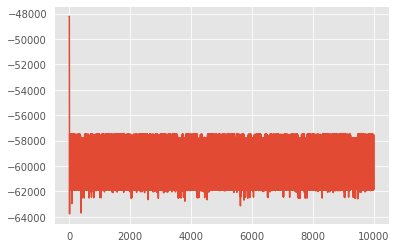

In [204]:
plt.plot(post_samples.disc_logprob)

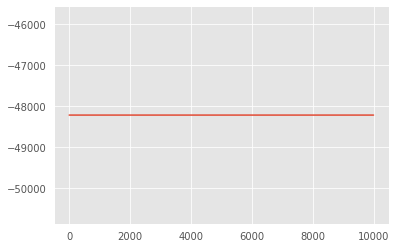

In [205]:
plt.plot(post_samples.contin_logprob)

In [189]:
get_ess(post_samples.position.discrete_position[int(burnin*num_samples):], burnin)

DeviceArray([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
             8.1000000e+03, 1.0000000e+00, 8.1000000e+03, 8.1000000e+03,
             8.1000000e+03, 8.1000000e+03, 8.1000000e+03, 8.1000000e+03,
             8.1000000e+03, 8.1000000e+03, 8.100000

In [190]:
np.mean(np.sum(post_samples.position.discrete_position[int(burnin*num_samples):], axis=1), axis=0)

DeviceArray(97.44356, dtype=float32)

In [191]:
get_ess(post_samples.position.contin_position["beta"], burnin)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [60]:
jnp.mean(post_samples.position.discrete_position[int(burnin*num_samples):], axis=0)

DeviceArray([0.6666667 , 0.33333334, 0.33333334, 0.6666667 , 0.33333334,
             0.33333334, 0.6666667 , 0.33333334, 0.33333334, 0.33333334,
             0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.33333334,
             0.        , 0.6666667 , 0.6666667 , 0.6666667 , 0.6666667 ,
             0.6666667 , 0.33333334, 0.6666667 , 0.6666667 , 0.6666667 ,
             0.33333334, 0.33333334, 0.33333334, 0.6666667 , 0.33333334,
             0.33333334, 0.6666667 , 0.6666667 , 0.33333334, 0.6666667 ,
             0.6666667 , 1.        , 0.6666667 , 0.33333334, 0.33333334,
             0.6666667 , 1.        , 0.33333334, 0.33333334, 0.33333334,
             0.33333334, 0.33333334, 0.33333334, 0.6666667 , 0.6666667 ,
             0.6666667 , 0.33333334, 0.33333334, 0.6666667 , 0.33333334,
             0.6666667 , 0.33333334, 0.6666667 , 0.6666667 , 0.6666667 ,
             0.33333334, 0.6666667 , 0.6666667 , 0.33333334, 0.33333334,
             0.6666667 , 0.33333334, 0.33333334, 0.

In [61]:
after_burnin = num_samples - int(burnin*num_samples)

count = jnp.sum(post_samples.position.discrete_position[-after_burnin:] == jnp.ones((after_burnin, p)), axis=0)
count = count / after_burnin
idx = np.argwhere(count == 1)

In [62]:
idx

array([[ 36],
       [ 41],
       [140],
       [171],
       [197]], dtype=int32)

In [438]:
mask = np.zeros(p)
mask[idx] = 1.

In [439]:
beta_mean = jnp.mean(post_samples.position.contin_position["beta"][-after_burnin:], axis=0)

In [440]:
beta_mean[idx]

DeviceArray([[ 0.7793652 ],
             [ 0.65472424],
             [ 1.3554393 ],
             [ 0.2873859 ],
             [ 0.8651368 ],
             [ 1.064304  ],
             [ 1.3720478 ],
             [ 2.1502357 ],
             [ 1.4969984 ],
             [ 0.7380357 ],
             [ 0.42589447],
             [ 1.496183  ],
             [ 1.2750962 ],
             [ 0.4894644 ],
             [-1.1422236 ],
             [-1.9322939 ]], dtype=float32)

In [441]:
beta_mean

DeviceArray([ 0.04988884, -1.4763514 , -1.0037918 , -0.646032  ,
             -0.78511244,  0.12243191,  0.2189167 ,  0.7793652 ,
             -1.320902  , -0.6683453 , -1.0862435 , -0.9459912 ,
             -0.6953757 ,  0.65472424, -1.0500953 ,  1.3554393 ,
             -0.32465935, -0.7439053 , -0.3743278 ,  0.37750998,
             -1.3323117 , -0.891101  ,  0.2873859 ,  0.20574859,
             -1.2548807 ,  0.8651368 ,  0.08666334,  1.064304  ,
             -0.92414886, -0.62545484,  1.3720478 ,  0.19653115,
              2.1502357 , -0.9105317 , -0.50185776,  1.4969984 ,
              0.7380357 , -0.68939424, -0.01414957,  0.42589447,
              1.496183  ,  1.2750962 ,  0.4894644 , -1.3792808 ,
             -0.32487148,  0.37731716, -2.526175  , -2.1641498 ,
              1.0053191 , -0.71497744, -0.29956445,  0.93444663,
              1.3123035 ,  0.43158334,  0.25610253,  0.7249027 ,
             -0.979391  ,  1.1282829 ,  0.25673884,  0.0316744 ,
             -1.1320318 ,

In [442]:
y_train

array([-16.43064345, -44.52301487, -47.03722782,  24.83671888,
        -6.32733362,  35.19591026, -14.1746924 ,   6.05819514,
        71.34866981,   8.89598294,   6.79112717, -37.76036321,
        32.53587372, -24.98372392, -76.31231772,  55.48158119,
         7.07174034,  24.62862474, -49.84016726,  -5.66028485,
        21.30136923, -22.12926954, -18.69784576,  19.06767792,
        15.64283964,   0.37736688, -19.26471162,  12.31527468,
         1.12119291,   5.68984485,  38.26370577, -12.36302739,
       -21.12484137, -34.98658104,  -9.15289675,  13.2432983 ,
       -63.74302306,  -0.77788809,  45.94037846,   4.31170086,
        32.53579374,  68.23226933,  43.29437402, -36.24684565,
        35.38599582,  -6.64109961,  21.10623385,  -4.3913634 ,
        -6.40550389,  43.23361408,  13.32671114,  71.30412534,
        80.40365332, -40.11093094,  46.22111628,   4.55309902,
       -44.42406127,   9.06467769,   7.0142362 ,  52.09668813,
         0.97031959,  19.2269571 ,  32.64188839,  89.29

In [443]:
clf = LinearRegression()
clf.fit(X_train, y_train)
mean_squared_error(y_train ,clf.predict(X_train))

2.4587082869310646e-27

In [444]:
mean_squared_error(y_train, (X_train @ (beta_mean * mask)))

941.5871456093985

In [267]:
(X @ (beta_mean * mask)).shape

(100,)

In [249]:
jnp.mean(post_samples.position.contin_position["beta"][int(burnin*num_samples):], axis=0)

DeviceArray([ 0.2792703 , -0.18597655,  0.30200517,  0.2838874 ,
             -0.19167244,  1.5195519 ,  0.42364323,  0.10489247,
              0.15010683, -0.07017838,  0.3615261 , -1.4708123 ,
             -1.3895881 ,  0.10029171,  1.3744712 ,  0.0314678 ,
             -0.5983568 , -1.0812591 ,  0.47836947,  0.74597526],            dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (220,) and (1, 4)

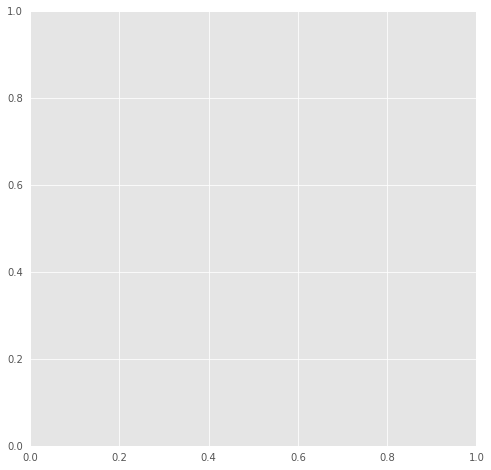

In [257]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(0, p), jnp.mean(post_samples.position.contin_position["beta"][int(burnin*num_samples):], axis=0), color="orange")
ax.axvline(x=44, linestyle="--", color="blue", label="i = 44")

In [247]:
# rng_key = jax.random.PRNGKey(1254)
# logprob = lambda x: jnp.sum(jax.vmap(joint.log_prob)(x))
# mala = blackjax.mala(logprob, 1e-5)
# initial_position = joint.sample(seed=jax_prng_key(), sample_shape=(10,))
# print(logprob(initial_position))
# initial_state = mala.init(initial_position)
# mala_kernel = jax.jit(mala.step)
# states = inference_loop(rng_key, mala_kernel, initial_state, 10_000)

inf


2022-08-09 16:53:56.446317: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB (rounded to 1760000000)requested by op 
2022-08-09 16:53:56.446639: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] ******_***_______________________*******************************************************____________
2022-08-09 16:53:56.447232: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1760000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   853.3KiB
              constant allocation:        24B
        maybe_live_out allocation:    6.74GiB
     preallocated temp allocation:    1.11MiB
  preallocated temp fragmentation:     1.1KiB (0.10%)
                 total allocation:    6.74GiB
Peak buffe

KeyboardInterrupt: 

In [315]:
get_ess(states.position["beta"], 0.0)

DeviceArray([[1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             ...,
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [316]:
stp = states.position[int(num_samples*0.1):]
mean_stp = jnp.mean(stp, axis=0)[0]

TypeError: unhashable type: 'slice'

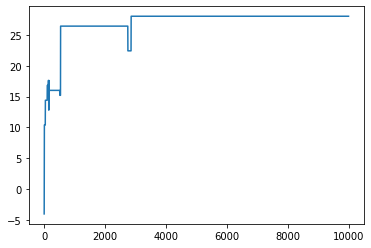

In [ ]:
plt.plot(states.logprob)

In [ ]:
mu_list = jnp.array([-2., 4.]).reshape(n_comp,)
Sigma_list = (1. * jnp.stack([np.eye(1) for _ in range(pi.shape[0])])).reshape(n_comp,)
temperature = 0.2

def select_cat(p):
  i = jnp.argmax(p)
  return i

joint_dist = tfd.JointDistributionSequential([
                 tfd.RelaxedBernoulli(probs=pi, temperature=temperature),         
    lambda p: tfd.Normal(loc=mu_list[jnp.argmax(p)], scale=Sigma_list[jnp.argmax(p)])
])


In [ ]:
def joint_logprob(z, x):
  return joint_dist.log_prob([z, x])

In [ ]:

x = joint_dist.sample(seed=jax_prng_key(), sample_shape=(1,))


In [ ]:
x

[DeviceArray([[1.7705379e-11, 2.2592945e-03]], dtype=float32),
 DeviceArray(5.6057415, dtype=float32)]

In [ ]:
x[0]

DeviceArray([[9.9999881e-01, 8.2526243e-01],
             [9.9205482e-01, 9.8945552e-01],
             [2.2606441e-04, 9.6258480e-04],
             ...,
             [1.2734017e-03, 9.9919862e-01],
             [7.6786989e-01, 1.3903156e-04],
             [9.9999607e-01, 1.3607772e-02]], dtype=float32)

In [ ]:
x[1]

In [ ]:
joint = tfd.JointDistributionSequential([
                 tfd.Exponential(rate=[100, 120]),           # e
    lambda    e: tfd.Gamma(concentration=e[0], rate=e[1]),    # g
                 tfd.Normal(loc=0, scale=2.),                 # n
    lambda n, g: tfd.Normal(loc=n, scale=g),                   # m
    lambda    m: tfd.Sample(tfd.Bernoulli(logits=m), 12)      # x
], batch_ndims=0, use_vectorized_map=True)
joint.sample(seed=jax_prng_key())

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:1833: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:1966: UserWarning: Expl

[DeviceArray([0.03947287, 0.02690292], dtype=float32),
 DeviceArray(9.018711e-29, dtype=float32),
 DeviceArray(0.5695137, dtype=float32),
 DeviceArray(0.5695137, dtype=float32),
 DeviceArray([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int32)]